In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

c:\Users\MONSTER\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Model test kodu

eps = 1e-7

def recall_at_k(y_true, y_prob, k=0.1):
    """
    Tahmin edilen olasılıkların en üst k%'sını pozitif etiketleyerek recall değerini hesaplar.

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.
        k (float): Pozitif etiketlenecek olasılıkların yüzdelik dilimi (varsayılan 0.1).

    Döndürür:
        float: En iyi k% tahminlerindeki recall oranı.
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]

    tp_at_k = y_true[top].sum()
    P = y_true.sum()

    return float(tp_at_k / P) if P > 0 else 0.0


def lift_at_k(y_true, y_prob, k=0.1):
    """
    Tahmin edilen olasılıkların en üst k%'sını pozitif etiketleyerek lift (precision/prevalence) değerini hesaplar.

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.
        k (float): Pozitif etiketlenecek olasılıkların yüzdelik dilimi (varsayılan 0.1).

    Döndürür:
        float: En iyi k% tahminlerindeki lift değeri.
    """
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    n = len(y_true)
    m = max(1, int(np.round(k * n)))
    order = np.argsort(-y_prob, kind="mergesort")
    top = order[:m]

    tp_at_k = y_true[top].sum()
    precision_at_k = tp_at_k / m
    prevalence = y_true.mean()

    return float(precision_at_k / prevalence) if prevalence > 0 else 0.0


def convert_auc_to_gini(auc):
    """
    ROC AUC skorunu Gini katsayısına dönüştürür.

    Gini katsayısı, ROC AUC skorunun doğrusal bir dönüşümüdür.

    Parametreler:
        auc (float): ROC AUC skoru (0 ile 1 arasında).

    Döndürür:
        float: Gini katsayısı (-1 ile 1 arasında).
    """
    return 2 * auc - 1


def ing_hubs_datathon_metric(y_true, y_prob):
    """
    Gini, recall@10% ve lift@10% metriklerini birleştiren özel bir metrik hesaplar.

    Metrik, her bir skoru bir baseline modelin metrik değerlerine göre oranlar ve aşağıdaki ağırlıkları uygular:
    - Gini: %40
    - Recall@10%: %30
    - Lift@10%: %30

    Parametreler:
        y_true (list): Gerçek ikili etiketler.
        y_prob (list): Tahmin edilen olasılıklar.

    Döndürür:
        float: Ağırlıklandırılmış bileşik skor.
    """
    # final metrik için ağırlıklar
    score_weights = {
        "gini": 0.4,
        "recall_at_10perc": 0.3,
        "lift_at_10perc": 0.3,
    }

    # baseline modelin her bir metrik için değerleri
    baseline_scores = {
        "roc_auc": 0.6925726757936908,
        "recall_at_10perc": 0.18469015795868773,
        "lift_at_10perc": 1.847159286784029,
    }

    # y_prob tahminleri için metriklerin hesaplanması
    roc_auc = roc_auc_score(y_true, y_prob)
    recall_at_10perc = recall_at_k(y_true, y_prob, k=0.1)
    lift_at_10perc = lift_at_k(y_true, y_prob, k=0.1)

    new_scores = {
        "roc_auc": roc_auc,
        "recall_at_10perc": recall_at_10perc,
        "lift_at_10perc": lift_at_10perc,
    }

    # roc auc değerlerinin gini değerine dönüştürülmesi
    baseline_scores["gini"] = convert_auc_to_gini(baseline_scores["roc_auc"])
    new_scores["gini"] = convert_auc_to_gini(new_scores["roc_auc"])

    # baseline modeline oranlama
    final_gini_score = new_scores["gini"] / (baseline_scores["gini"] + eps)
    final_recall_score = new_scores["recall_at_10perc"] / (baseline_scores["recall_at_10perc"] + eps)
    final_lift_score = new_scores["lift_at_10perc"] / (baseline_scores["lift_at_10perc"] + eps)

    # ağırlıklandırılmış metriğin hesaplanması
    final_score = (
        final_gini_score * score_weights["gini"] +
        final_recall_score * score_weights["recall_at_10perc"] + 
        final_lift_score * score_weights["lift_at_10perc"]
    )
    return final_score

In [4]:
def ing_hubs_datathon_metric_wrapper(y_true, y_prob, **kwargs):
    
    return ing_hubs_datathon_metric(y_true, y_prob)

In [5]:
def plot_feature_importance(model, feature_names, top_n=20):
    
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1][:top_n]
    
    plt.figure(figsize=(8, 4))
    plt.title(f'Top {top_n} Önemli Özellikler')
    plt.bar(range(top_n), importance[indices])
    plt.xticks(range(top_n), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    importance_df = pd.DataFrame({
        'Feature': feature_names[indices],
        'Importance': importance[indices]
    })
    
    return importance_df

In [6]:
def evaluate_model(model, X, y, title="Model Değerlendirme"):
    
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    final_score = ing_hubs_datathon_metric(y_true=y, y_prob=y_pred_proba)
    auc_score = roc_auc_score(y, y_pred_proba)
    recall_10 = recall_at_k(y, y_pred_proba, k=0.1)
    lift_10 = lift_at_k(y, y_pred_proba, k=0.1)
    
    print(f"\n{title}")
    print("-" * 40)
    print(f"Final Score: {final_score:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Recall@10%: {recall_10:.4f}")
    print(f"Lift@10%: {lift_10:.4f}")
    
    return final_score

In [7]:
def create_base_aggregations(df, num_cols, windows):
    """Temel zaman pencereli agregasyonları oluşturur"""
    
    features = []
    
    for window_name, window_days in windows.items():
        temp = (
            df[df["days_diff"] <= window_days]
            .groupby("cust_id")[num_cols]
            .agg(["mean", "sum", "std", "min", "max"])
        )
        temp.columns = [f"{col}_{stat}_{window_name}" for col, stat in temp.columns]
        features.append(temp)

    return pd.concat(features, axis=1)

In [8]:
def create_recency_features(df):    
    """İşlem yakınlığı özelliklerini oluşturur"""
    
    df_cc_active = df[df['cc_transaction_all_cnt'] > 0]
    df_eft_active = df[df['mobile_eft_all_cnt'] > 0]
    
    recency_cc = df_cc_active.groupby('cust_id')['days_diff'].min().rename('recency_days_cc')
    recency_eft = df_eft_active.groupby('cust_id')['days_diff'].min().rename('recency_days_eft')
    
    recency_features = pd.DataFrame({
        'recency_days_cc': recency_cc,
        'recency_days_eft': recency_eft
    })
    
    recency_features = recency_features.fillna(999)
    return recency_features

In [9]:
def create_activity_features(df):
    """
    Aktivite bazlı üç sayısal özellik döndürür:
    active_days_6m: Son 6 ayda kaç farklı günde aktif olduğu
    active_months_6m: Son 6 ayda kaç farklı ayda aktif olduğu (en fazla 6)
    activity_frequency_6m: Aktif olunan ay başına ortalama aktif gün sayısı
    """

    df['date'] = pd.to_datetime(df['date'])
    recent_df = df[df['days_diff'] <= 180].copy()

    active_days = (
        recent_df.groupby('cust_id')['date']
        .nunique()
        .rename('active_days_6m')
    )

    recent_df['month'] = recent_df['date'].dt.to_period('M')
    active_months = (
        recent_df.groupby('cust_id')['month']
        .nunique()
        .rename('active_months_6m')
    )

    result = pd.concat([active_days, active_months], axis=1).fillna(0)
    result['activity_frequency_6m'] = np.where(
        result['active_months_6m'] > 0,
        result['active_days_6m'] / result['active_months_6m'], 
        0
    )
    
    return result[['active_days_6m', 'active_months_6m', 'activity_frequency_6m']]

In [10]:
def create_trend_features(df):
    """Trend ve oran bazlı özellikleri oluşturur"""
    
    features = {}
    
    with np.errstate(divide='ignore', invalid='ignore'):
        features['cc_trend_amt_1m_vs_3m'] = (
            df['cc_transaction_all_amt_sum_1m'] * 3) / df['cc_transaction_all_amt_sum_3m']
        
        features['eft_trend_cnt_1m_vs_3m'] = (
            df['mobile_eft_all_cnt_sum_1m'] * 3) / df['mobile_eft_all_cnt_sum_3m']

        features['cc_avg_amt_per_txn_6m'] = (
            df['cc_transaction_all_amt_sum_6m'] / df['cc_transaction_all_cnt_sum_6m'])
        
        features['eft_avg_amt_per_txn_6m'] = (
            df['mobile_eft_all_amt_sum_6m'] / df['mobile_eft_all_cnt_sum_6m'])

        total_transactions_6m = df['mobile_eft_all_cnt_sum_6m'] + df['cc_transaction_all_cnt_sum_6m']
        features['eft_ratio_vs_total_cnt_6m'] = df['mobile_eft_all_cnt_sum_6m'] / total_transactions_6m
        
    return pd.DataFrame(features)

In [11]:
def create_weighted_features(df):
    """Zaman bazlı ağırlıklandırılmış özellikler oluşturur"""
    
    weights = {"1m": 0.6, "3m": 0.3, "6m": 0.1}
    keywords = ['sum', 'mean', 'min', 'max', 'std']
    
    weighted_features = {}
    for period, weight in weights.items():
        cols = [col for col in df.columns if period in col and any(i in col for i in keywords)]
        for col in cols:
            weighted_features[f"weighted_{col}"] = df[col] * weight
            
    return pd.DataFrame(weighted_features)

In [12]:
def create_transaction_intensity_features(df):
    """İşlem yoğunluğu özellikleri oluşturur"""

    features = {}
    
    # Aktif ay başına düşen işlem sayısı
    features['cc_tx_per_active_month'] = (
        df['cc_transaction_all_cnt_sum_6m'] / df['active_months_6m'].clip(lower=1)
    )
    features['eft_tx_per_active_month'] = (
        df['mobile_eft_all_cnt_sum_6m'] / df['active_months_6m'].clip(lower=1)
    )
    
    # Son ay/3 ay oranları
    features['cc_momentum'] = (
        df['cc_transaction_all_cnt_sum_1m'] * 3 / 
        df['cc_transaction_all_cnt_sum_3m'].clip(lower=1)
    )
    features['eft_momentum'] = (
        df['mobile_eft_all_cnt_sum_1m'] * 3 / 
        df['mobile_eft_all_cnt_sum_3m'].clip(lower=1)
    )
    
    return pd.DataFrame(features)

In [13]:
def create_volatility_features(df):
    """İşlem değişkenliği özellikleri oluşturur"""

    features = {}
    
    for period in ['1m', '3m', '6m']:
        for metric in ['cc_transaction_all_amt', 'mobile_eft_all_amt']:
            mean_col = f"{metric}_mean_{period}"
            std_col = f"{metric}_std_{period}"
            features[f"{metric}_cv_{period}"] = (
                df[std_col] / df[mean_col].clip(lower=1)
            )
    
    return pd.DataFrame(features)

In [14]:
def create_enhanced_features(df):

    num_cols = [
        "mobile_eft_all_cnt", "mobile_eft_all_amt",
        "cc_transaction_all_amt", "cc_transaction_all_cnt",
        "active_product_category_nbr"
    ]
    
    windows = {"1m": 30, "3m": 90, "6m": 180}
    
    base_features = create_base_aggregations(df, num_cols, windows)
    recency_features = create_recency_features(df)
    activity_features = create_activity_features(df)

    base_features = pd.concat([base_features, activity_features], axis=1)

    trend_features = create_trend_features(base_features)
    weighted_features = create_weighted_features(base_features)
    intensity_features = create_transaction_intensity_features(base_features)
    volatility_features = create_volatility_features(base_features)

    all_features = pd.concat([
        base_features,
        recency_features,
        trend_features,
        weighted_features,
        intensity_features,
        volatility_features,
    ], axis=1)

    all_features = all_features.reset_index()
    all_features = all_features.replace([np.inf, -np.inf], np.nan)
    trend_cols = [col for col in all_features.columns if 'trend' in col]
    all_features[trend_cols] = all_features[trend_cols].fillna(1)
    all_features = all_features.fillna(0)
    
    return all_features

In [15]:
customer_history = pd.read_csv("datasets/customer_history.csv")
customers = pd.read_csv("datasets/customers.csv")
sample_submission = pd.read_csv("datasets/sample_submission.csv")
ref_data = pd.read_csv("datasets/referance_data.csv")
ref_data_test = pd.read_csv("datasets/referance_data_test.csv")

In [16]:
customer_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5359609 entries, 0 to 5359608
Data columns (total 7 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   cust_id                      int64  
 1   date                         object 
 2   mobile_eft_all_cnt           float64
 3   active_product_category_nbr  int64  
 4   mobile_eft_all_amt           float64
 5   cc_transaction_all_amt       float64
 6   cc_transaction_all_cnt       float64
dtypes: float64(4), int64(2), object(1)
memory usage: 286.2+ MB


In [17]:
customer_history.isnull().sum()

cust_id                             0
date                                0
mobile_eft_all_cnt             112334
active_product_category_nbr         0
mobile_eft_all_amt             112334
cc_transaction_all_amt         166746
cc_transaction_all_cnt         166746
dtype: int64

In [18]:
cols_to_fill = ['mobile_eft_all_cnt', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'cc_transaction_all_cnt']
customer_history[cols_to_fill] = customer_history[cols_to_fill].fillna(0)

In [19]:
customer_history.isnull().sum()

cust_id                        0
date                           0
mobile_eft_all_cnt             0
active_product_category_nbr    0
mobile_eft_all_amt             0
cc_transaction_all_amt         0
cc_transaction_all_cnt         0
dtype: int64

In [20]:
customer_history.head()

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt
0,0,2016-01-01,1.0,2,151.20,0.0,0.0
1,0,2016-02-01,1.0,2,178.70,0.0,0.0
2,0,2016-03-01,2.0,2,37.38,0.0,0.0
3,0,2016-04-01,4.0,2,100.90,0.0,0.0
4,0,2016-05-01,3.0,3,132.28,0.0,0.0


In [21]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176293 entries, 0 to 176292
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   cust_id      176293 non-null  int64 
 1   gender       176293 non-null  object
 2   age          176293 non-null  int64 
 3   province     176293 non-null  object
 4   religion     176293 non-null  object
 5   work_type    176293 non-null  object
 6   work_sector  146159 non-null  object
 7   tenure       176293 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 10.8+ MB


In [22]:
customers.head()

,cust_id,gender,age,province,religion,work_type,work_sector,tenure
0,0,F,64,NOH,U,Part-time,Technology,135
1,1,F,57,ZUI,O,Full-time,Finance,65
2,2,F,62,NOB,M,Self-employed,Healthcare,224
3,3,F,22,ZUI,C,Student,NaN,47
4,5,M,27,ZUI,U,Full-time,Finance,108


In [23]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43006 entries, 0 to 43005
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cust_id  43006 non-null  int64
 1   churn    43006 non-null  int64
dtypes: int64(2)
memory usage: 672.1 KB


In [24]:
sample_submission.head()

,cust_id,churn
0,1,0
1,2,0
2,9,0
3,15,0
4,19,0


In [25]:
ref_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133287 entries, 0 to 133286
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   cust_id   133287 non-null  int64 
 1   ref_date  133287 non-null  object
 2   churn     133287 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.1+ MB


In [26]:
ref_data.head()

,cust_id,ref_date,churn
0,0,2017-09-01,0
1,3,2018-10-01,0
2,5,2018-03-01,1
3,6,2018-04-01,1
4,7,2018-05-01,0


In [27]:
ref_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43006 entries, 0 to 43005
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cust_id   43006 non-null  int64 
 1   ref_date  43006 non-null  object
dtypes: int64(1), object(1)
memory usage: 672.1+ KB


In [28]:
ref_data_test.head()

,cust_id,ref_date
0,1,2019-02-01
1,2,2019-01-01
2,9,2019-03-01
3,15,2019-06-01
4,19,2019-01-01


In [29]:
customer_history["date"] = pd.to_datetime(customer_history["date"])
ref_data_test["ref_date"] = pd.to_datetime(ref_data_test["ref_date"])
ref_data["ref_date"] = pd.to_datetime(ref_data["ref_date"])

In [30]:
train_merged = pd.merge(ref_data, customer_history, on="cust_id", how="left", suffixes=("_ref", "_hist"))

test_merged = pd.merge(ref_data_test, customer_history, on="cust_id", how="left", suffixes=("_ref", "_hist"))

In [31]:
train_merged["days_diff"] = (train_merged["ref_date"] - train_merged["date"]).dt.days
test_merged["days_diff"] = (test_merged["ref_date"] - test_merged["date"]).dt.days

In [32]:
# Sadece geçmişteki işlemleri alıyoruz

train_merged = train_merged[train_merged["days_diff"] >= 0].copy()
test_merged = test_merged[test_merged["days_diff"] >= 0].copy()

In [33]:
train_merged.head()

,cust_id,ref_date,churn,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,days_diff
0,0,2017-09-01,0,2016-01-01,1.0,2,151.20,0.0,0.0,609
1,0,2017-09-01,0,2016-02-01,1.0,2,178.70,0.0,0.0,578
2,0,2017-09-01,0,2016-03-01,2.0,2,37.38,0.0,0.0,549
3,0,2017-09-01,0,2016-04-01,4.0,2,100.90,0.0,0.0,518
4,0,2017-09-01,0,2016-05-01,3.0,3,132.28,0.0,0.0,488


In [34]:
train_feats = create_enhanced_features(train_merged)
test_feats = create_enhanced_features(test_merged)

print(train_feats.shape, test_feats.shape)

(133287, 171) (43006, 171)


In [35]:
train_feats.head()

,cust_id,mobile_eft_all_cnt_mean_1m,mobile_eft_all_cnt_sum_1m,mobile_eft_all_cnt_std_1m,mobile_eft_all_cnt_min_1m,mobile_eft_all_cnt_max_1m,mobile_eft_all_amt_mean_1m,mobile_eft_all_amt_sum_1m,mobile_eft_all_amt_std_1m,mobile_eft_all_amt_min_1m,...,cc_tx_per_active_month,eft_tx_per_active_month,cc_momentum,eft_momentum,cc_transaction_all_amt_cv_1m,mobile_eft_all_amt_cv_1m,cc_transaction_all_amt_cv_3m,mobile_eft_all_amt_cv_3m,cc_transaction_all_amt_cv_6m,mobile_eft_all_amt_cv_6m
0,0,1.0,1.0,0.000000,1.0,1.0,212.750,212.75,0.000000,212.75,...,0.000000,2.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.262563,0.000000,0.427462
1,3,1.5,3.0,0.707107,1.0,2.0,416.030,832.06,117.323157,333.07,...,20.000000,1.166667,1.965517,2.250000,0.359178,0.282006,0.254050,0.376137,0.533799,0.529222
2,5,4.5,9.0,0.707107,4.0,5.0,1056.895,2113.79,472.184695,723.01,...,2.666667,3.833333,1.250000,1.687500,0.165566,0.446766,0.252804,0.410695,0.199913,0.417676
3,6,6.0,6.0,0.000000,6.0,6.0,262.550,262.55,0.000000,262.55,...,1.333333,5.166667,0.500000,0.818182,0.000000,0.000000,0.229196,0.227675,0.196342,0.230659
4,7,0.0,0.0,0.000000,0.0,0.0,0.000,0.00,0.000000,0.00,...,74.333333,0.000000,1.561644,0.000000,0.196870,0.000000,0.122846,0.000000,0.124702,0.000000


In [36]:
train_final = (
    ref_data
    .merge(train_feats, on="cust_id", how="left")
    .merge(customers, on="cust_id", how="left")
)

test_final = (
    ref_data_test
    .merge(test_feats, on="cust_id", how="left")
    .merge(customers, on="cust_id", how="left")
)

In [37]:
# Tüm türetilmiş özelliklerin eksik değerlerini 0 ile doldurur

feat_cols = [col for col in test_final.columns if '1m' in col or '3m' in col or '6m' in col]
train_final[feat_cols] = train_final[feat_cols].fillna(0)
test_final[feat_cols] = test_final[feat_cols].fillna(0)

# Demografik verideki NaN'ı doldurma (Örneğin: work_sector)

train_final["work_sector"] = train_final["work_sector"].fillna("UNKNOWN") 
test_final["work_sector"] = test_final["work_sector"].fillna("UNKNOWN")

In [38]:
categorical_cols = ['gender', 'province', 'religion', 'work_type', 'work_sector']

train_final = pd.get_dummies(train_final, columns=categorical_cols, drop_first=True)
test_final = pd.get_dummies(test_final, columns=categorical_cols, drop_first=True)

train_labels = set(train_final.columns)
test_labels = set(test_final.columns)
missing_in_test = train_labels - test_labels
missing_in_train = test_labels - train_labels

for col in missing_in_test:
    if col != 'churn': 
        test_final[col] = 0

for col in missing_in_train:
    train_final[col] = 0

test_final = test_final[train_final.drop('churn', axis=1).columns]

for col in train_final.columns:
    if train_final[col].dtype == 'bool':
        train_final[col] = train_final[col].astype(int)

for col in test_final.columns:
    if test_final[col].dtype == 'bool':
        test_final[col] = test_final[col].astype(int)

In [39]:
train_final.isnull().sum().sum()

0

In [40]:
test_final.isnull().sum().sum()

0

In [41]:
train_final.shape, test_final.shape

((133287, 203), (43006, 202))

In [42]:
train_final.head()

,cust_id,ref_date,churn,mobile_eft_all_cnt_mean_1m,mobile_eft_all_cnt_sum_1m,mobile_eft_all_cnt_std_1m,mobile_eft_all_cnt_min_1m,mobile_eft_all_cnt_max_1m,mobile_eft_all_amt_mean_1m,mobile_eft_all_amt_sum_1m,...,work_type_Self-employed,work_type_Student,work_type_Unemployed,work_sector_Finance,work_sector_Healthcare,work_sector_Manufacturing,work_sector_Public Sector,work_sector_Retail,work_sector_Technology,work_sector_UNKNOWN
0,0,2017-09-01,0,1.0,1.0,0.000000,1.0,1.0,212.750,212.75,...,0,0,0,0,0,0,0,0,1,0
1,3,2018-10-01,0,1.5,3.0,0.707107,1.0,2.0,416.030,832.06,...,0,1,0,0,0,0,0,0,0,1
2,5,2018-03-01,1,4.5,9.0,0.707107,4.0,5.0,1056.895,2113.79,...,0,0,0,1,0,0,0,0,0,0
3,6,2018-04-01,1,6.0,6.0,0.000000,6.0,6.0,262.550,262.55,...,0,0,1,0,0,0,0,0,0,1
4,7,2018-05-01,0,0.0,0.0,0.000000,0.0,0.0,0.000,0.00,...,0,0,0,0,0,0,1,0,0,0


In [43]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133287 entries, 0 to 133286
Columns: 203 entries, cust_id to work_sector_UNKNOWN
dtypes: datetime64[ns](1), float64(159), int32(28), int64(15)
memory usage: 192.2 MB


In [44]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43006 entries, 0 to 43005
Columns: 202 entries, cust_id to work_sector_UNKNOWN
dtypes: datetime64[ns](1), float64(159), int32(28), int64(14)
memory usage: 61.7 MB


In [45]:
X = train_final.drop(columns=["cust_id", "ref_date", "churn"])
y = train_final["churn"]
submission_cust_ids = test_final['cust_id']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ing_hubs_score = make_scorer(ing_hubs_datathon_metric_wrapper, needs_proba=True)

In [46]:
def objective(trial):
    param = {
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.03, 0.05, 0.07, 0.1]),
        'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [1, 2, 3, 4, 5]),
    }

    model = CatBoostClassifier(
        **param,
        scale_pos_weight=pos_weight,
        random_seed=42,
        logging_level='Silent',
        eval_metric='AUC',
        task_type="GPU"
    )
    
    score = cross_val_score(model, X_train_scaled, y_train, cv=cv_strategy, scoring=ing_hubs_score).mean()

    return score

In [47]:
search_space = {
    'depth': list(range(6, 11)),
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'l2_leaf_reg': [1, 2, 3, 4, 5]
}

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=30) 

[I 2025-10-22 12:15:23,439] A new study created in memory with name: no-name-d5a11fb1-a0b2-437d-aec0-6106323dfa9d
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-10-22 12:19:17,192] Trial 0 finished with value: 0.8382903954276737 and parameters: {'depth': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.8382903954276737.
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemente

In [48]:
print(f"En İyi Deneme Skoru: {study.best_value:.6f}")
print("En İyi Parametreler:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

En İyi Deneme Skoru: 0.838290
En İyi Parametreler:
    depth: 10
    learning_rate: 0.01
    l2_leaf_reg: 5


In [49]:
best_params = study.best_params

best_model = CatBoostClassifier(
    **best_params,
    scale_pos_weight=pos_weight,
    random_seed=42,
    logging_level='Silent',
    eval_metric='AUC',
    task_type="GPU"
)

best_model.fit(X_train_scaled, y_train)

Default metric period is 5 because AUC is/are not implemented for GPU


In [50]:
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
validation_score = ing_hubs_datathon_metric(y_true=y_val, y_prob=y_val_proba)
validation_score

1.0854389891829357

In [51]:
y_val_pred = best_model.predict(X_val_scaled)

print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     22884
           1       0.23      0.62      0.34      3774

    accuracy                           0.66     26658
   macro avg       0.57      0.64      0.55     26658
weighted avg       0.82      0.66      0.71     26658

Confusion Matrix:
[[15259  7625]
 [ 1451  2323]]


In [52]:
evaluate_model(best_model, X_val_scaled, y_val, title="Validasyon Seti Değerlendirmesi")


Validasyon Seti Değerlendirmesi
----------------------------------------
Final Score: 1.0854
AUC Score: 0.7010
Recall@10%: 0.2056
Lift@10%: 2.0560


1.0854389891829357

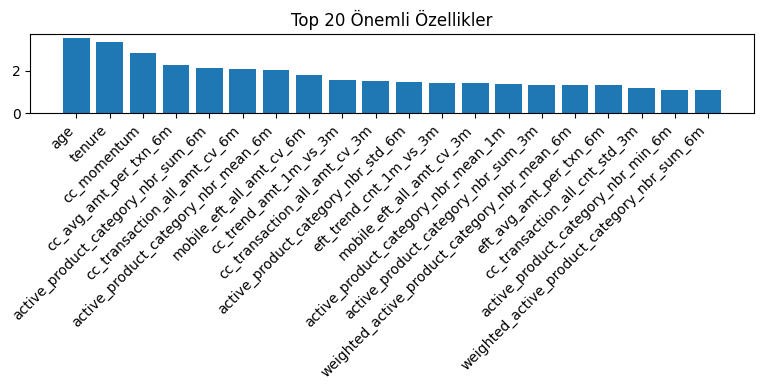

,Feature,Importance
0,age,3.529566
1,tenure,3.362286
2,cc_momentum,2.834819
3,cc_avg_amt_per_txn_6m,2.261036
4,active_product_category_nbr_sum_6m,2.114276
5,cc_transaction_all_amt_cv_6m,2.070680
6,active_product_category_nbr_mean_6m,2.040601
7,mobile_eft_all_amt_cv_6m,1.823658
8,cc_trend_amt_1m_vs_3m,1.582805
9,cc_transaction_all_amt_cv_3m,1.523863


In [53]:
plot_feature_importance(best_model, feature_names=X.columns, top_n=20)

In [64]:
importances = best_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

num_features_to_drop = 25 
features_to_drop_df = feature_importance_df.head(num_features_to_drop)

print(f"Atılacak en az önemli {num_features_to_drop} özellik ve skorları:")
print(features_to_drop_df.to_string()) 

Atılacak en az önemli 25 özellik ve skorları:
                                         Feature  Importance
75                                active_days_6m    0.000000
76                              active_months_6m    0.000000
77                         activity_frequency_6m    0.000000
22            active_product_category_nbr_std_1m    0.005554
182                                 province_ZEE    0.005575
107  weighted_active_product_category_nbr_std_1m    0.005585
174                                 province_FRI    0.011774
191                            work_type_Student    0.014945
178                                 province_NOB    0.049594
196                    work_sector_Public Sector    0.050707
181                                 province_UTR    0.053743
78                               recency_days_cc    0.053997
184                                   religion_J    0.060169
176                                 province_GRO    0.064874
189                            work_typ

In [65]:
final_model = CatBoostClassifier(**best_params, 
                                 scale_pos_weight=pos_weight, 
                                 random_seed=42, 
                                 logging_level='Silent', 
                                 eval_metric='AUC',
                                 task_type="GPU")

In [66]:
features_to_drop_list = features_to_drop_df['Feature'].tolist()

train_final_reduced = train_final.drop(columns=features_to_drop_list)
test_final_reduced = test_final.drop(columns=features_to_drop_list)

print(f"Train setinin yeni boyutu: {train_final_reduced.shape}")
print(f"Test setinin yeni boyutu: {test_final_reduced.shape}")

Train setinin yeni boyutu: (133287, 178)
Test setinin yeni boyutu: (43006, 177)


In [67]:
new_scaler = StandardScaler()

X = train_final_reduced.drop(columns=["cust_id", "ref_date", "churn"])
y = train_final_reduced["churn"]
X_submission = test_final_reduced.drop(columns=["cust_id", "ref_date"])

X_scaled = new_scaler.fit_transform(X)
X_submission_scaled = new_scaler.transform(X_submission)

final_model.fit(X_scaled, y)

Default metric period is 5 because AUC is/are not implemented for GPU


In [68]:
final_model_score = ing_hubs_datathon_metric(y_true=y, y_prob=final_model.predict_proba(X_scaled)[:, 1])
final_model_score

1.9560100244832315

In [69]:
submission_probabilities = final_model.predict_proba(X_submission_scaled)[:, 1]
submission_df = pd.DataFrame({'cust_id': submission_cust_ids, 'churn': submission_probabilities})
submission_df.to_csv('submission_final.csv', index=False)